# Sentiment Analysis for LGBT-Related Reddit Posts in Spanish

This notebook performs sentiment analysis on Spanish Reddit posts related to LGBT topics. The goal is to classify posts as having negative (NEG), neutral (NEU), or positive (POS) sentiment.

## Dataset
- Training data: train.csv
- Evaluation data: dev.csv

## Task Overview
We will build models to classify posts into three sentiment categories:
- Negative (NEG) - encoded as 0
- Neutral (NEU) - encoded as 1
- Positive (POS) - encoded as 2

## Cell 1: Load and Explore Data

First, let's load the training and development data and perform some exploratory analysis.

Training data preview:


,id,country,keyword,post content,label
0,A4184,Argentina,travesti,"¿Un `travesti`? Fija que es parte de la campaña **""No te comas el verso, come de verdad""**",NEU
1,A3962,Argentina,travesti,El `travesti` era el comisario y el conductor del auto la bicicleta.,NEU
2,A0321,Argentina,bisexuales,"Si, amigos y parejas amigas. Tanto homosexuales como `bisexuales`. S'all cool. \n\n- Como nacio ...",POS
3,A1258,Argentina,lesbiana,es `lesbiana` ensima,NEU
4,A3307,Argentina,transexuales,"Es que no es respetar su nombre, es como dijo otro comentario: no te vas a acostumbrar de un día...",NEG



Development data preview:


,id,country,keyword,post content,label
0,A2442,Argentina,trans,Me tiene los huevos al plato la gente que no quiere bajarse de la palmera y piensa que el resto ...,NEU
1,A0021,Argentina,gay,>El Che guevara era 100% antigay\n\n¿Cuál es tu fuente? ⛲¿Te basás en lo que escribió en diarios...,NEU
2,A2678,Argentina,trans,No seas malo. Es `trans` pero hay que dejarlo vivir.,NEG
3,A2016,Argentina,trans,Imaginate defender a un tipo que golpea minas solo porque quienes lo cagaron a piñas eran `trans`,NEU
4,A1844,Argentina,trans,"El no binario es difícil, no viví esa experiencia y la verdad no te puedo hablar desde ese lugar...",NEU



Training data shape: (5767, 5)
Development data shape: (1443, 5)

Missing values in training data:
id              0
country         0
keyword         0
post content    0
label           0
dtype: int64

Missing values in development data:
id              0
country         0
keyword         0
post content    0
label           0
dtype: int64

Label distribution in training data:
label
NEU    3174
NEG    1960
POS     633
Name: count, dtype: int64

Percentage:
label
NEU    55.037281
NEG    33.986475
POS    10.976244
Name: count, dtype: float64

Label distribution in development data:
label
NEU    888
NEG    475
POS     80
Name: count, dtype: int64

Percentage:
label
NEU    61.538462
NEG    32.917533
POS     5.544006
Name: count, dtype: float64


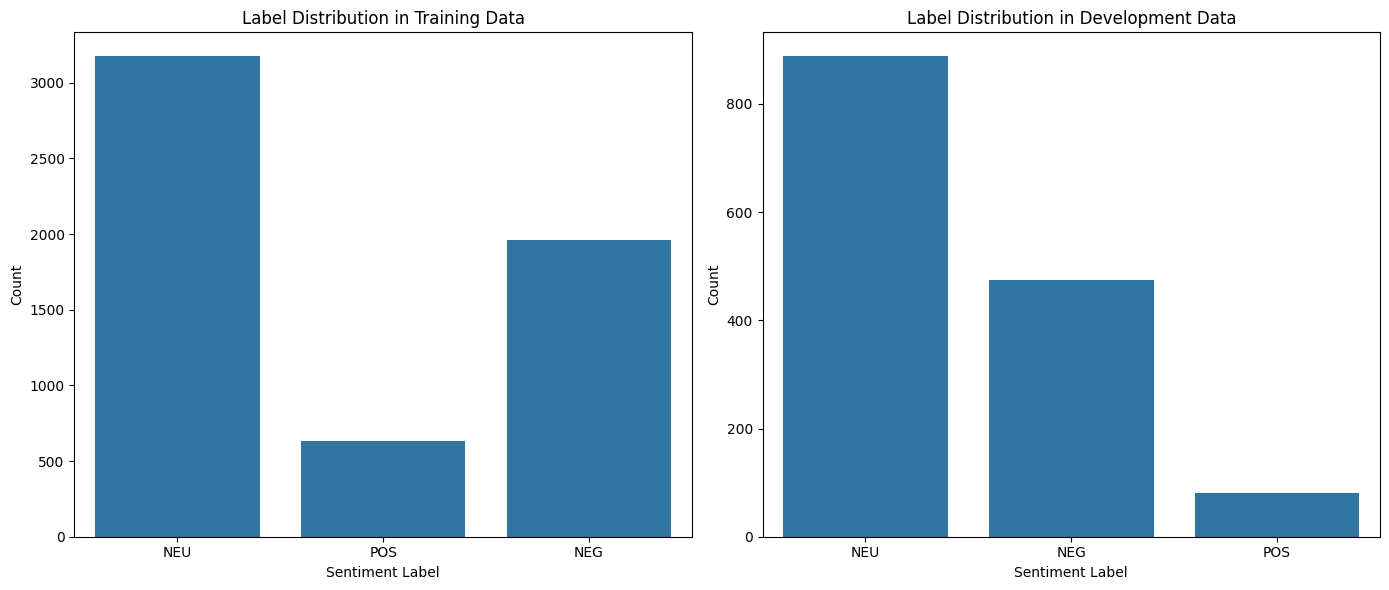

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set display options for better visualization
pd.set_option('display.max_colwidth', 100)

# Load the datasets
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')

# Look at the first few rows of each dataset
print("Training data preview:")
display(train_df.head())
print("\nDevelopment data preview:")
display(dev_df.head())

# Dataset shapes
print(f"\nTraining data shape: {train_df.shape}")
print(f"Development data shape: {dev_df.shape}")

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in development data:")
print(dev_df.isnull().sum())

# Encode labels (NEG as 0, NEU as 1, POS as 2)
label_map = {'NEG': 0, 'NEU': 1, 'POS': 2}
train_df['label_encoded'] = train_df['label'].map(label_map)
dev_df['label_encoded'] = dev_df['label'].map(label_map)

# Analyze label distribution
train_label_counts = train_df['label'].value_counts()
dev_label_counts = dev_df['label'].value_counts()

print("\nLabel distribution in training data:")
print(train_label_counts)
print("\nPercentage:")
print(train_label_counts / len(train_df) * 100)

print("\nLabel distribution in development data:")
print(dev_label_counts)
print("\nPercentage:")
print(dev_label_counts / len(dev_df) * 100)

# Visualize label distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=train_df)
plt.title('Label Distribution in Training Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='label', data=dev_df)
plt.title('Label Distribution in Development Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Cell 2: Text Preprocessing

In this cell, we'll preprocess the text data by:
1. Converting emojis to words
2. Processing emoticons
3. Removing special characters
4. Removing URLs
5. Normalizing text (lowercase, etc.)

In [2]:
# Import necessary libraries for text preprocessing
import re
import emoji
import string
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load Spanish language model for spaCy
try:
    nlp = spacy.load('es_core_news_sm')
except OSError:
    print("Spanish language model not found. Installing...")
    import sys
    !{sys.executable} -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

# Define emoticons dictionary
emoticons = {
    ':)': 'sonrisa',
    ':(': 'triste',
    ':D': 'risa',
    ':-D': 'risa',
    ':P': 'sacando_lengua',
    ':-P': 'sacando_lengua',
    ':p': 'sacando_lengua',
    ':-p': 'sacando_lengua',
    ';)': 'guiño',
    ':-|': 'serio',
    ':|': 'serio',
    ':o': 'sorprendido',
    ':O': 'sorprendido',
    ':-o': 'sorprendido',
    ':-O': 'sorprendido',
    ':/': 'escéptico',
    ':-/': 'escéptico',
    ':S': 'confundido',
    ':s': 'confundido',
    ':-S': 'confundido',
    ':-s': 'confundido',
    '<3': 'amor',
    '</3': 'corazón_roto',
    ':*': 'beso',
    ':-*': 'beso',
    'xD': 'carcajada',
    'XD': 'carcajada',
    'x-D': 'carcajada',
    'X-D': 'carcajada'
}

def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert text to string if not already
    text = str(text)
    
    # Convert emojis to words
    text = emoji.demojize(text, language='es')
    
    # Replace emoticons with their meanings
    for emoticon, meaning in emoticons.items():
        text = text.replace(emoticon, f" {meaning} ")
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove Markdown formatting
    text = re.sub(r'\*\*|\*|__|_|~~|\[|\]|\(|\)|#|>|`', '', text)
    
    # Remove Reddit-specific formatting
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)
    text = re.sub(r'/s|/S', '', text)  # Remove sarcasm tags
    text = re.sub(r'&amp;|&lt;|&gt;|&quot;|&#x200B;', '', text)  # Remove HTML entities
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation (except for apostrophes, which can be important in Spanish)
    punctuation_to_remove = string.punctuation.replace("'", "")
    translator = str.maketrans('', '', punctuation_to_remove)
    text = text.translate(translator)
    
    # Optional: Lemmatization using spaCy
    # doc = nlp(text)
    # text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
    return text.strip()

# Apply preprocessing to the datasets
train_df['processed_text'] = train_df['post content'].apply(preprocess_text)
dev_df['processed_text'] = dev_df['post content'].apply(preprocess_text)

# Display sample before and after preprocessing
sample_idx = min(5, len(train_df) - 1)

print("Sample text before preprocessing:")
print(train_df['post content'].iloc[sample_idx])
print("\nSample text after preprocessing:")
print(train_df['processed_text'].iloc[sample_idx])

# Count keywords in the dataset
keyword_counts = Counter(train_df['keyword'])
print("\nTop 10 keywords in the dataset:")
print(keyword_counts.most_common(10))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample text before preprocessing:
Deberíamos hacer cambios para que haya al menos 1% de cupo `trans` de titulares del senado.

Sample text after preprocessing:
deberíamos hacer cambios para que haya al menos 1 de cupo trans de titulares del senado

Top 10 keywords in the dataset:
[('trans', 1780), ('gay', 1464), ('lgbt', 581), ('gays', 372), ('LGBT', 219), ('bisexual', 212), ('lesbiana', 204), ('travesti', 135), ('lesbianas', 123), ('travestis', 101)]


## Cell 3: Feature Engineering

Here, we'll transform the text into features using multiple techniques:
1. Bag of Words (BoW)
2. TF-IDF with unigrams and bigrams
3. Word2Vec embeddings

BoW vocabulary size: 13627
BoW train features shape: (5767, 13627)
BoW dev features shape: (1443, 13627)
TF-IDF vocabulary size: 52341
TF-IDF train features shape: (5767, 52341)
TF-IDF dev features shape: (1443, 52341)
Word2Vec train features shape: (5767, 100)
Word2Vec dev features shape: (1443, 100)


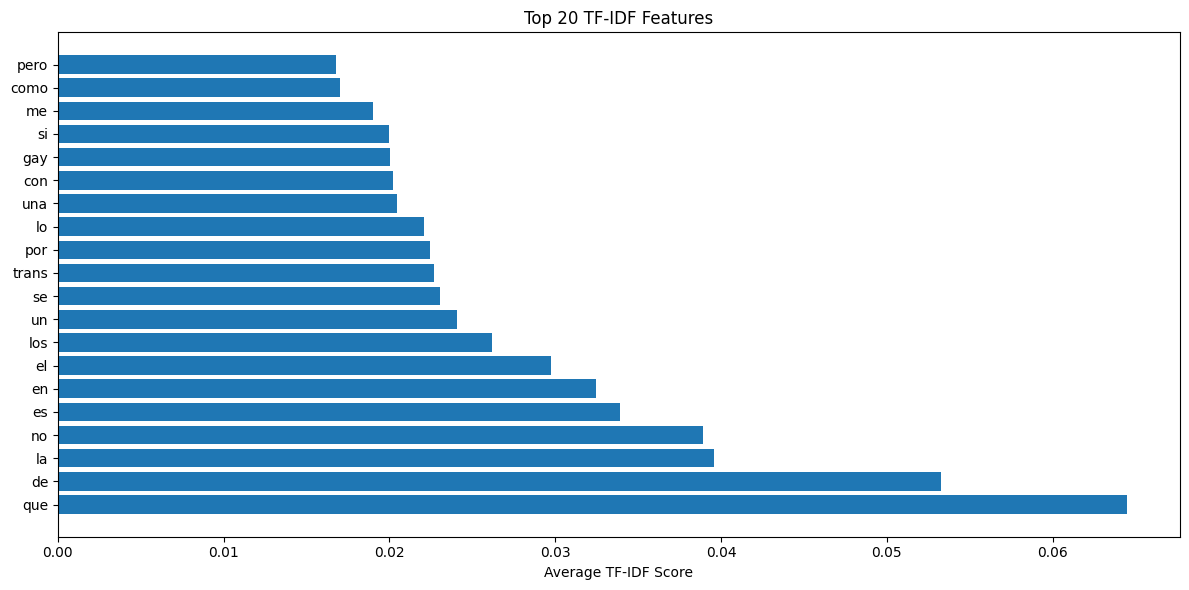

In [3]:
# Import necessary libraries for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Function to tokenize text for Word2Vec
def tokenize_text(text):
    return word_tokenize(text)

# Tokenize texts for Word2Vec
train_tokens = [tokenize_text(text) for text in train_df['processed_text']]
dev_tokens = [tokenize_text(text) for text in dev_df['processed_text']]

# 1. Bag of Words (BoW) Vectorization
bow_vectorizer = CountVectorizer(min_df=2, max_df=0.95)
bow_train = bow_vectorizer.fit_transform(train_df['processed_text'])
bow_dev = bow_vectorizer.transform(dev_df['processed_text'])

print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")
print(f"BoW train features shape: {bow_train.shape}")
print(f"BoW dev features shape: {bow_dev.shape}")

# 2. TF-IDF Vectorization with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1, 2))
tfidf_train = tfidf_vectorizer.fit_transform(train_df['processed_text'])
tfidf_dev = tfidf_vectorizer.transform(dev_df['processed_text'])

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"TF-IDF train features shape: {tfidf_train.shape}")
print(f"TF-IDF dev features shape: {tfidf_dev.shape}")

# 3. Word2Vec Embeddings
# Train Word2Vec model on our dataset
w2v_model = Word2Vec(sentences=train_tokens + dev_tokens, 
                     vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Function to create document vectors from Word2Vec embeddings
def document_vector(doc, model):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    # Return average of word vectors
    return np.mean([model.wv[word] for word in doc], axis=0)

# Create document vectors for train and dev sets
train_w2v = np.array([document_vector(doc, w2v_model) for doc in train_tokens])
dev_w2v = np.array([document_vector(doc, w2v_model) for doc in dev_tokens])

print(f"Word2Vec train features shape: {train_w2v.shape}")
print(f"Word2Vec dev features shape: {dev_w2v.shape}")

# Store feature sets for later use
feature_sets = {
    'bow': {'train': bow_train, 'dev': bow_dev, 'vectorizer': bow_vectorizer},
    'tfidf': {'train': tfidf_train, 'dev': tfidf_dev, 'vectorizer': tfidf_vectorizer},
    'w2v': {'train': train_w2v, 'dev': dev_w2v, 'model': w2v_model}
}

# Visualize top TF-IDF features
def get_top_n_features(vectorizer, X, n=20):
    feature_names = vectorizer.get_feature_names_out()
    
    # Get the mean TF-IDF score for each feature across all documents
    mean_tfidf = X.mean(axis=0).A1
    
    # Get indices of top features
    top_indices = mean_tfidf.argsort()[-n:][::-1]
    
    return [(feature_names[i], mean_tfidf[i]) for i in top_indices]

top_features = get_top_n_features(tfidf_vectorizer, tfidf_train, n=20)

# Plotting
plt.figure(figsize=(12, 6))

# Extract words and scores
words, scores = zip(*top_features)

# Plot horizontal bar chart
plt.barh(range(len(words)), scores)
plt.yticks(range(len(words)), words)
plt.xlabel('Average TF-IDF Score')
plt.title('Top 20 TF-IDF Features')
plt.tight_layout()
plt.show()

## Cell 4: Handle Data Imbalance

Here, we'll address the data imbalance using SMOTE (Synthetic Minority Over-sampling Technique).

Original training class distribution:
Counter({1: 3174, 0: 1960, 2: 633})

After SMOTE for bow:
Resampled features shape: (9522, 13627)
Resampled class distribution: Counter({1: 3174, 2: 3174, 0: 3174})

After SMOTE for tfidf:
Resampled features shape: (9522, 52341)
Resampled class distribution: Counter({1: 3174, 2: 3174, 0: 3174})

After SMOTE for w2v:
Resampled features shape: (9522, 100)
Resampled class distribution: Counter({1: 3174, 2: 3174, 0: 3174})


C:\Users\ACER\AppData\Local\Temp\ipykernel_14140\3510066270.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, order=[0, 1, 2], palette='viridis')
C:\Users\ACER\AppData\Local\Temp\ipykernel_14140\3510066270.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, order=[0, 1, 2], palette='viridis')


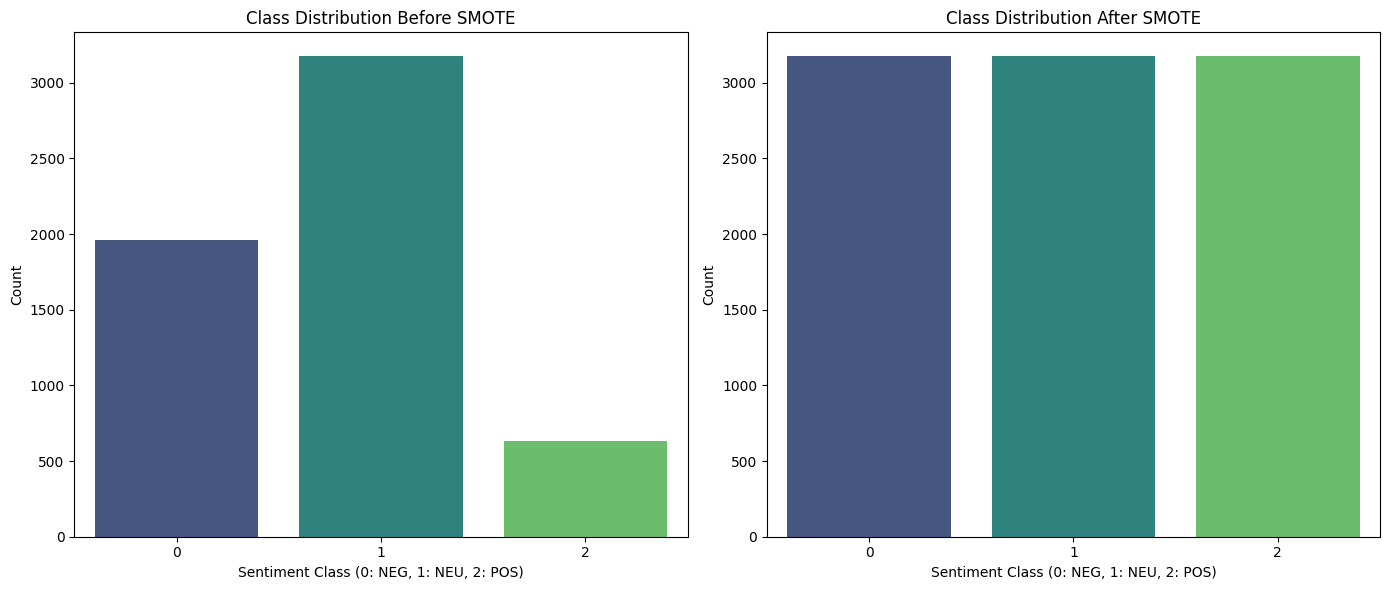

In [4]:
# Import necessary libraries for handling imbalanced data
from imblearn.over_sampling import SMOTE
from collections import Counter

# Get the training labels
y_train = train_df['label_encoded'].values
y_dev = dev_df['label_encoded'].values

print("Original training class distribution:")
print(Counter(y_train))

# Apply SMOTE for each feature set
smote = SMOTE(random_state=42)
balanced_feature_sets = {}

for name, features in feature_sets.items():
    if name in ['bow', 'tfidf']:
        # Convert to dense array for SMOTE if sparse
        X_resampled, y_resampled = smote.fit_resample(features['train'], y_train)
        balanced_feature_sets[name] = {
            'train': X_resampled,
            'dev': features['dev'],
            'vectorizer': features['vectorizer']
        }
    else:  # for Word2Vec, which is already a dense array
        X_resampled, y_resampled = smote.fit_resample(features['train'], y_train)
        balanced_feature_sets[name] = {
            'train': X_resampled,
            'dev': features['dev'],
            'model': features['model']
        }
    
    print(f"\nAfter SMOTE for {name}:")
    print(f"Resampled features shape: {X_resampled.shape}")
    print(f"Resampled class distribution: {Counter(y_resampled)}")

# Store the resampled labels for training
y_train_resampled = y_resampled

# Visualize class distribution before and after SMOTE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, order=[0, 1, 2], palette='viridis')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Sentiment Class (0: NEG, 1: NEU, 2: POS)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, order=[0, 1, 2], palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Sentiment Class (0: NEG, 1: NEU, 2: POS)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Cell 5: Model Training with Hyperparameter Tuning

In this cell, we'll train multiple models with different parameters using GridSearchCV.

In [5]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
import warnings
import time

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Dictionary to store all trained models for each feature type
all_models = {}

# Define models and their parameter grids
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga'],
            'penalty': [ 'l1','l2'], 
            'class_weight': ['balanced']
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced']
        }
    }
}

# Results to store all model performances
results = []

# Train models for each feature set
for feature_name, feature_set in balanced_feature_sets.items():
    print(f"\n=== Training models with {feature_name} features ===\n")
    
    X_train = feature_set['train']
    X_dev = feature_set['dev']
    
    # Scale features for Word2Vec
    if feature_name == 'w2v':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_dev = scaler.transform(X_dev)
        # Cannot use MultinomialNB with negative values
        model_list = {k: v for k, v in model_params.items() if k != 'MultinomialNB'}
        # Use GaussianNB instead
        model_list['GaussianNB'] = {
            'model': GaussianNB(),
            'params': {}
        }
    else:
        model_list = model_params
    
    # Store models for this feature set
    all_models[feature_name] = {}
    
    # Train each model with grid search
    for model_name, mp in model_list.items():
        start_time = time.time()
        print(f"Training {model_name} with {feature_name}...")
        
        # Create the grid search
        grid_search = GridSearchCV(
            estimator=mp['model'],
            param_grid=mp['params'],
            scoring='f1_macro',
            cv=5,
            n_jobs=-1
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train_resampled)
        
        # Best model
        best_model = grid_search.best_estimator_
        all_models[feature_name][model_name] = best_model
        
        # Predict on dev set
        y_pred = best_model.predict(X_dev)
        
        # Calculate metrics
        accuracy = accuracy_score(y_dev, y_pred)
        f1_macro = f1_score(y_dev, y_pred, average='macro')
        recall_macro = recall_score(y_dev, y_pred, average='macro')
        
        # Time taken
        time_taken = time.time() - start_time
        
        # Store results
        results.append({
            'feature_type': feature_name,
            'model': model_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'recall_macro': recall_macro,
            'best_params': grid_search.best_params_,
            'time_taken': time_taken
        })
        
        print(f"{model_name} with {feature_name} - Accuracy: {accuracy:.4f}, F1 Macro: {f1_macro:.4f}, Recall Macro: {recall_macro:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Training time: {time_taken:.2f} seconds\n")

# Create a DataFrame with all results
results_df = pd.DataFrame(results)

# Sort by F1 score (descending)
results_df = results_df.sort_values('f1_macro', ascending=False)

print("\n=== Model Performance Sorted by F1 Macro Score (Dev Set) ===\n")
print(results_df[['feature_type', 'model', 'accuracy', 'f1_macro', 'recall_macro']])


=== Training models with bow features ===

Training Logistic Regression with bow...
Logistic Regression with bow - Accuracy: 0.4830, F1 Macro: 0.3788, Recall Macro: 0.4031
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Training time: 920.76 seconds

Training SVC with bow...
SVC with bow - Accuracy: 0.4976, F1 Macro: 0.3703, Recall Macro: 0.3778
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Training time: 255.99 seconds

Training MultinomialNB with bow...
MultinomialNB with bow - Accuracy: 0.5232, F1 Macro: 0.3722, Recall Macro: 0.3733
Best parameters: {'alpha': 0.1}
Training time: 0.19 seconds

Training Decision Tree with bow...
Decision Tree with bow - Accuracy: 0.4026, F1 Macro: 0.3187, Recall Macro: 0.3425
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Training time: 11.82 seconds

Training Random Forest with bow...
Random For

## Cell 6: Evaluation on Dev Set

Let's evaluate all models on the dev set and compare their performance.

In [6]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store detailed results for all models
detailed_results = []

# Evaluate each model in detail
for feature_name, models in all_models.items():
    X_dev = balanced_feature_sets[feature_name]['dev']
    
    # Apply scaling for Word2Vec features
    if feature_name == 'w2v':
        scaler = StandardScaler()
        X_dev = scaler.fit_transform(X_dev)
    
    for model_name, model in models.items():
        # Predict on dev set
        y_pred = model.predict(X_dev)
        
        # Calculate metrics
        accuracy = accuracy_score(y_dev, y_pred)
        f1_macro = f1_score(y_dev, y_pred, average='macro')
        recall_macro = recall_score(y_dev, y_pred, average='macro')
        
        # Classification report
        report = classification_report(y_dev, y_pred, target_names=['NEG', 'NEU', 'POS'])
        
        # Confusion matrix
        cm = confusion_matrix(y_dev, y_pred)
        
        # Store detailed results
        detailed_results.append({
            'feature_type': feature_name,
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'recall_macro': recall_macro,
            'report': report,
            'cm': cm,
            'y_pred': y_pred
        })
        
        print(f"\n=== Detailed Evaluation for {model_name} with {feature_name} ===\n")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Macro: {f1_macro:.4f}")
        print(f"Recall Macro: {recall_macro:.4f}")
        print("\nClassification Report:")
        print(report)

# Create a dataframe for detailed results
detailed_results_df = pd.DataFrame([(d['feature_type'], d['model_name'], d['accuracy'], d['f1_macro'], d['recall_macro']) 
                                  for d in detailed_results], 
                                 columns=['Feature Type', 'Model', 'Accuracy', 'F1 Macro', 'Recall Macro'])

# Sort by F1 Macro score
detailed_results_df = detailed_results_df.sort_values('F1 Macro', ascending=False)

print("\n=== Summary of All Models Sorted by F1 Macro Score ===\n")
print(detailed_results_df)

# Results for each feature type
feature_performance = detailed_results_df.groupby('Feature Type')[['Accuracy', 'F1 Macro', 'Recall Macro']].mean()
print("\n=== Average Performance by Feature Type ===\n")
print(feature_performance)

# Results for each model type
model_performance = detailed_results_df.groupby('Model')[['Accuracy', 'F1 Macro', 'Recall Macro']].mean()
print("\n=== Average Performance by Model Type ===\n")
print(model_performance)


=== Detailed Evaluation for Logistic Regression with bow ===

Accuracy: 0.4830
F1 Macro: 0.3788
Recall Macro: 0.4031

Classification Report:
              precision    recall  f1-score   support

         NEG       0.41      0.42      0.42       475
         NEU       0.66      0.54      0.59       888
         POS       0.09      0.25      0.13        80

    accuracy                           0.48      1443
   macro avg       0.38      0.40      0.38      1443
weighted avg       0.54      0.48      0.51      1443


=== Detailed Evaluation for SVC with bow ===

Accuracy: 0.4976
F1 Macro: 0.3703
Recall Macro: 0.3778

Classification Report:
              precision    recall  f1-score   support

         NEG       0.39      0.43      0.41       475
         NEU       0.66      0.57      0.61       888
         POS       0.07      0.14      0.09        80

    accuracy                           0.50      1443
   macro avg       0.37      0.38      0.37      1443
weighted avg       0.54  

## Cell 7: Visualization of Results

Let's create visualizations of the model results and confusion matrices.

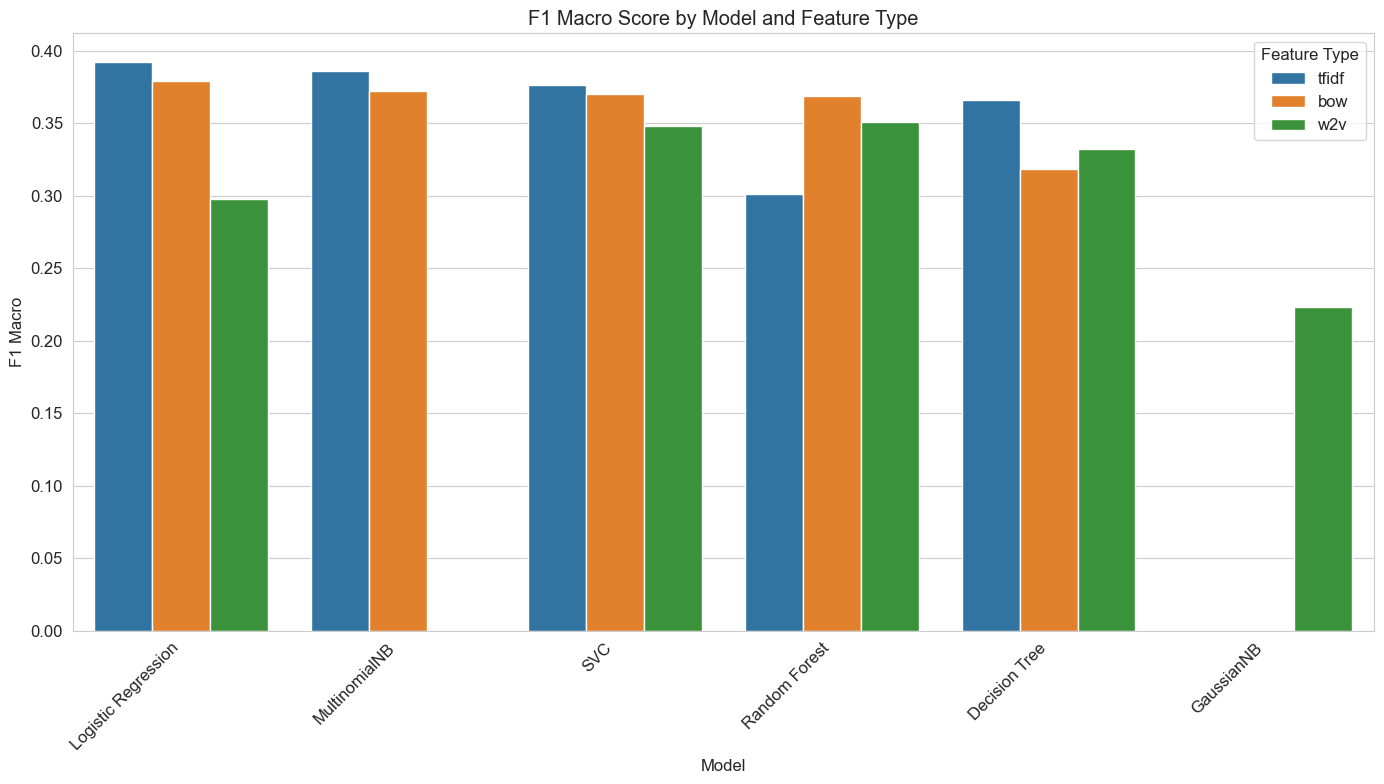

<Figure size 1600x1000 with 0 Axes>

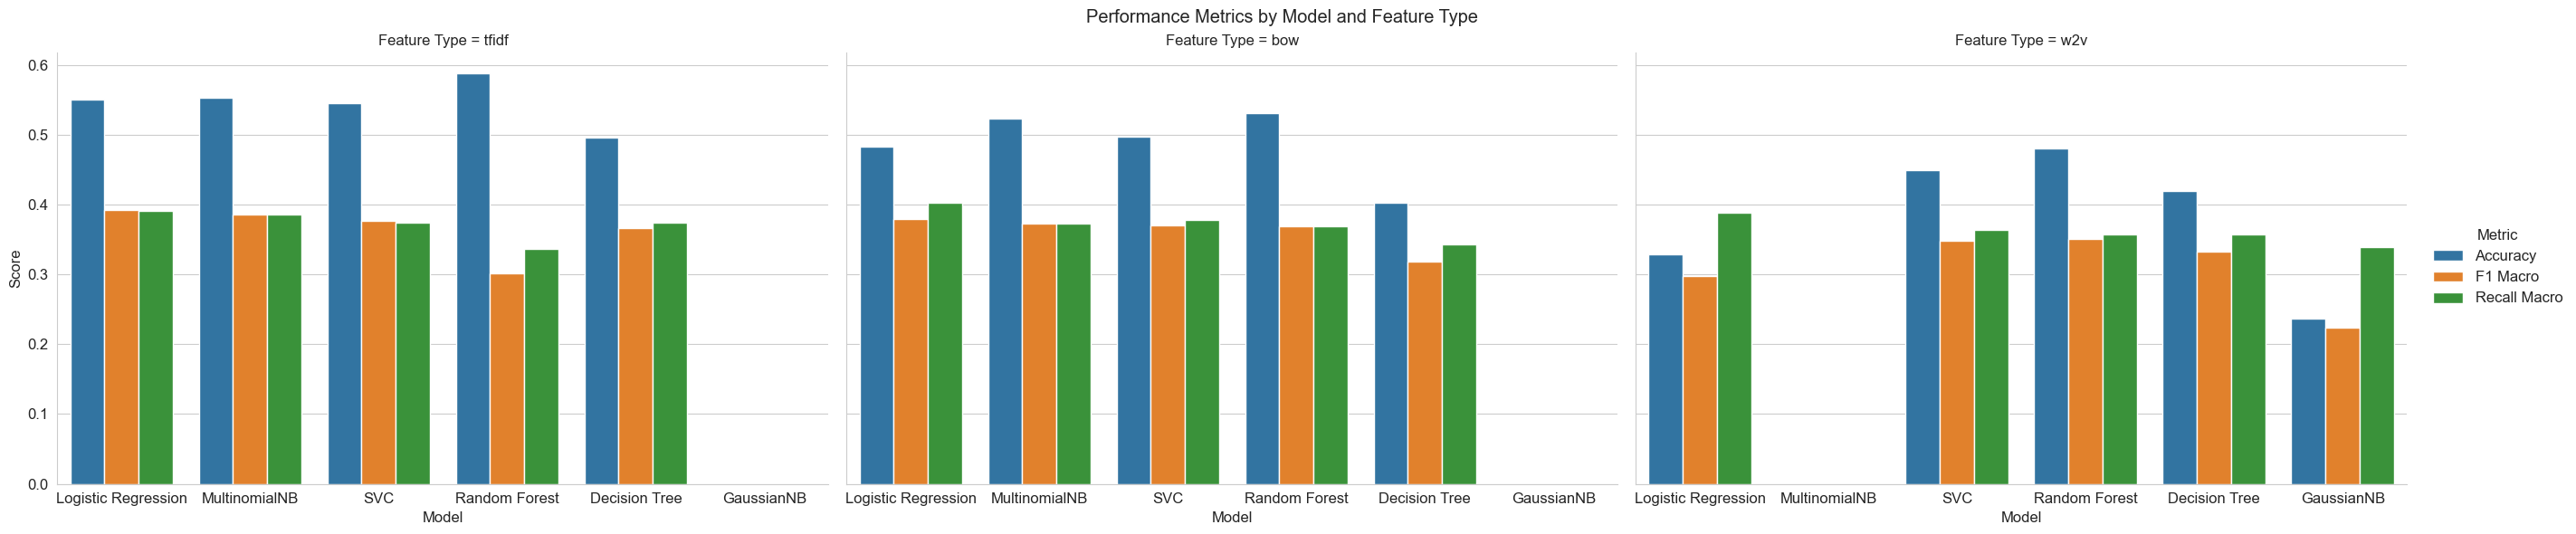

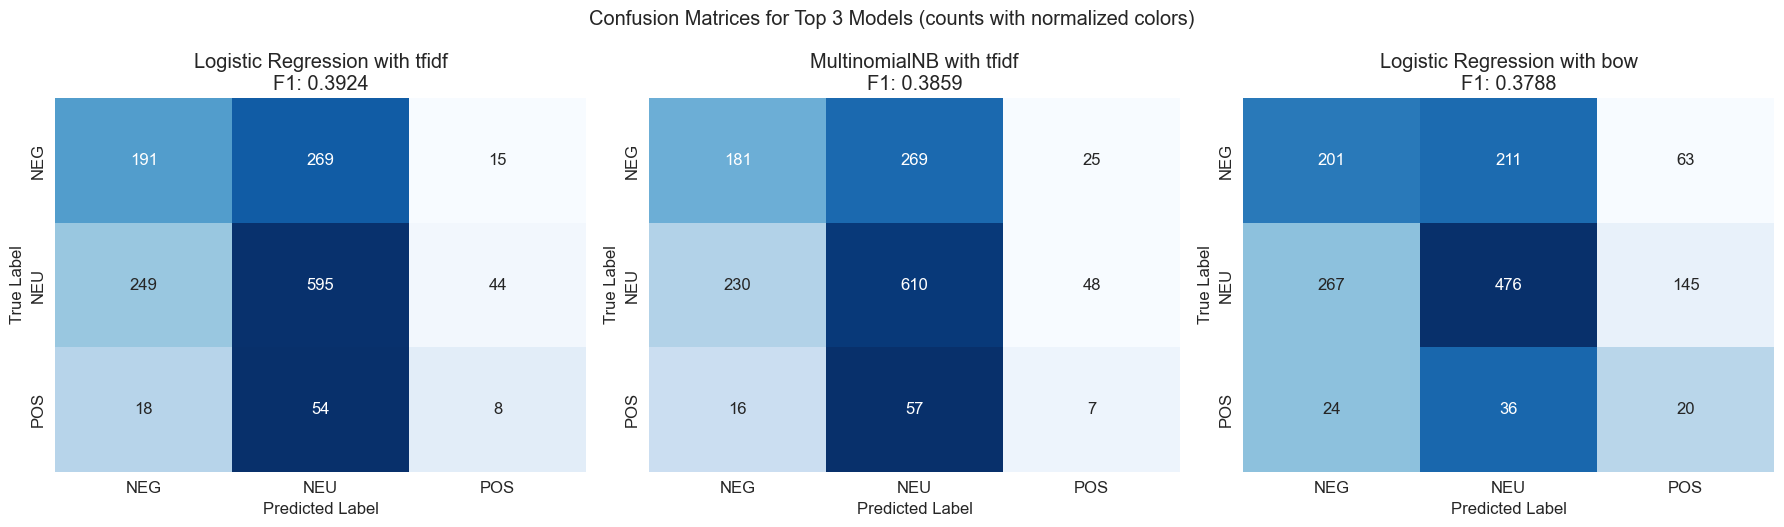

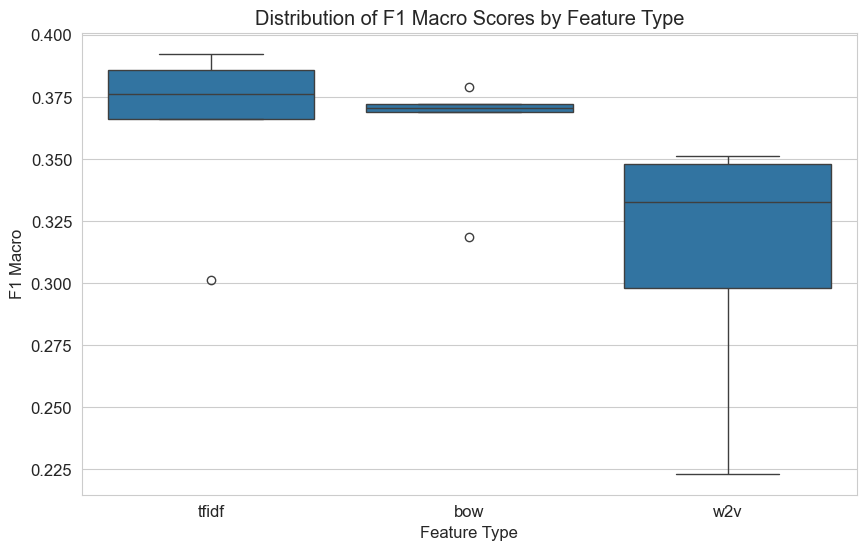

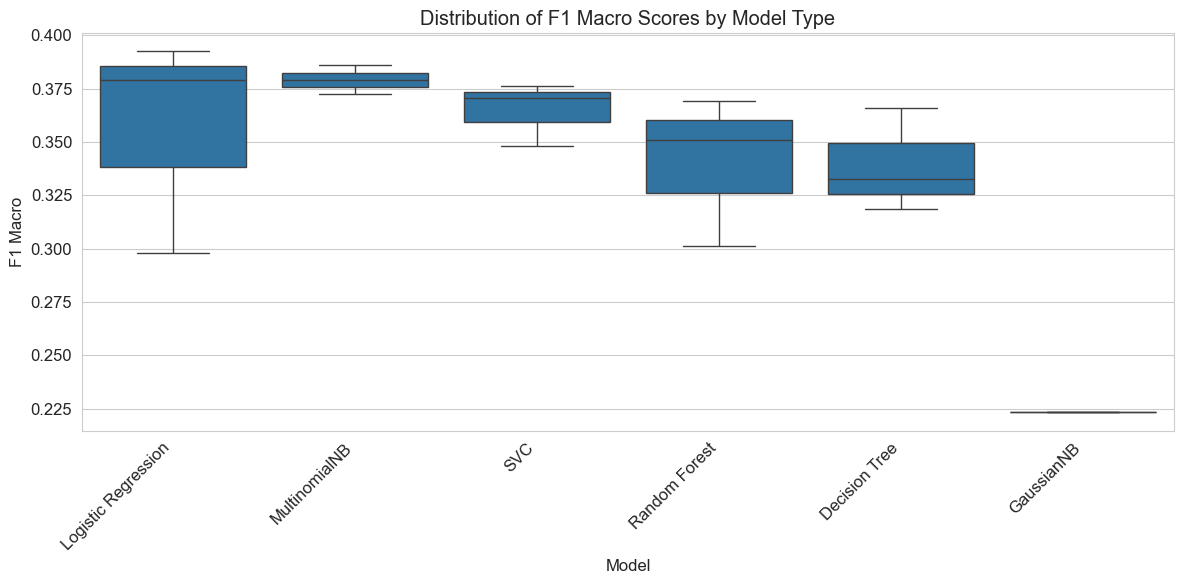

In [7]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. Bar chart of F1 scores across all models
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='F1 Macro', hue='Feature Type', data=detailed_results_df)
plt.title('F1 Macro Score by Model and Feature Type')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature Type')
plt.tight_layout()
plt.show()

# 2. Grouped bar chart for all metrics
metrics = ['Accuracy', 'F1 Macro', 'Recall Macro']
melted_df = pd.melt(detailed_results_df, 
                    id_vars=['Feature Type', 'Model'], 
                    value_vars=metrics,
                    var_name='Metric', value_name='Score')

plt.figure(figsize=(16, 10))
sns.catplot(x='Model', y='Score', hue='Metric', col='Feature Type', 
            data=melted_df, kind='bar', height=6, aspect=1.5)
plt.subplots_adjust(top=0.9)
plt.suptitle('Performance Metrics by Model and Feature Type')
plt.show()

# 3. Display confusion matrices for the top 3 models
top_models = detailed_results_df.head(3).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (idx, row) in enumerate(top_models.iterrows()):
    # Find corresponding detailed result
    model_result = next(d for d in detailed_results if d['feature_type'] == row['Feature Type'] and d['model_name'] == row['Model'])
    cm = model_result['cm']
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['NEG', 'NEU', 'POS'],
                yticklabels=['NEG', 'NEU', 'POS'],
                ax=axes[i])
    axes[i].set_title(f"{row['Model']} with {row['Feature Type']}\nF1: {row['F1 Macro']:.4f}")
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.suptitle('Confusion Matrices for Top 3 Models (counts with normalized colors)', y=1.05)
plt.show()

# 4. Boxplot of F1 scores by feature type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature Type', y='F1 Macro', data=detailed_results_df)
plt.title('Distribution of F1 Macro Scores by Feature Type')
plt.show()

# 5. Boxplot of F1 scores by model type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='F1 Macro', data=detailed_results_df)
plt.title('Distribution of F1 Macro Scores by Model Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Cell 8: Best Model Selection

Let's identify the best model based on the F1 macro score.


=== Best Model Selection ===

Best Model: SVC with bow features
F1 Macro Score: 0.3703
Accuracy: 0.4976
Recall Macro: 0.3778

Classification Report:
              precision    recall  f1-score   support

         NEG       0.39      0.43      0.41       475
         NEU       0.66      0.57      0.61       888
         POS       0.07      0.14      0.09        80

    accuracy                           0.50      1443
   macro avg       0.37      0.38      0.37      1443
weighted avg       0.54      0.50      0.52      1443


Best Model Parameters:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


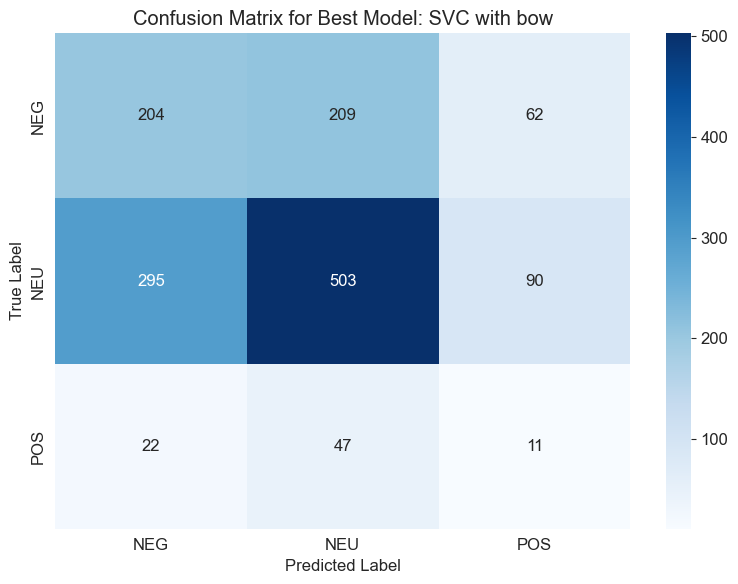

In [8]:
# Find the best model based on F1 macro score
best_model_idx = detailed_results_df['F1 Macro'].idxmax()
best_model_info = detailed_results_df.iloc[best_model_idx]

best_feature_type = best_model_info['Feature Type']
best_model_name = best_model_info['Model']
best_f1 = best_model_info['F1 Macro']
best_accuracy = best_model_info['Accuracy']
best_recall = best_model_info['Recall Macro']

print(f"\n=== Best Model Selection ===\n")
print(f"Best Model: {best_model_name} with {best_feature_type} features")
print(f"F1 Macro Score: {best_f1:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Recall Macro: {best_recall:.4f}")

# Get the actual model object
best_model = all_models[best_feature_type][best_model_name]

# Get detailed results for the best model
best_model_detailed = next(d for d in detailed_results 
                         if d['feature_type'] == best_feature_type and d['model_name'] == best_model_name)

# Print classification report
print("\nClassification Report:")
print(best_model_detailed['report'])

# Get best model parameters
print("\nBest Model Parameters:")
print(best_model.get_params())

# Confusion Matrix for the Best Model
plt.figure(figsize=(8, 6))
cm = best_model_detailed['cm']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEG', 'NEU', 'POS'],
            yticklabels=['NEG', 'NEU', 'POS'])
plt.title(f'Confusion Matrix for Best Model: {best_model_name} with {best_feature_type}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Cell 9: Save Trained Models

Let's save all the trained models along with vectorizers and feature extractors for future use.

In [9]:
# Import necessary libraries for saving models
import pickle
import os

# Create a directory for saving models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save all models and vectorizers
for feature_name, models in all_models.items():
    # Save feature extractor/vectorizer
    if feature_name in ['bow', 'tfidf']:
        vectorizer = balanced_feature_sets[feature_name]['vectorizer']
        with open(f'models/{feature_name}_vectorizer.pkl', 'wb') as f:
            pickle.dump(vectorizer, f)
        print(f"Saved {feature_name} vectorizer to models/{feature_name}_vectorizer.pkl")
    elif feature_name == 'w2v':
        w2v_model = balanced_feature_sets[feature_name]['model']
        w2v_model.save(f'models/word2vec_model.model')
        print(f"Saved Word2Vec model to models/word2vec_model.model")
    
    # Save all models for this feature type
    for model_name, model in models.items():
        filename = f'models/{feature_name}_{model_name.replace(" ", "_").lower()}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved {model_name} with {feature_name} features to {filename}")

# Save the best model specifically
best_model_filename = f'models/best_model_{best_feature_type}_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\nSaved best model to {best_model_filename}")

# Save model results summary
detailed_results_df.to_csv('models/model_results_summary.csv', index=False)
print("Saved model results summary to models/model_results_summary.csv")

# Save label encoder mapping
label_encoder = {'mapping': label_map, 'inverse_mapping': {v: k for k, v in label_map.items()}}
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Saved label encoder mapping to models/label_encoder.pkl")

print("\nAll models and supporting files have been saved successfully!")

# Function to load and use the best model for prediction
def predict_sentiment(text, model_path=best_model_filename):
    """
    Example function showing how to use the saved model for sentiment prediction.
    
    Args:
        text (str): Text input to classify
        model_path (str): Path to the saved model file
        
    Returns:
        str: Predicted sentiment (NEG, NEU, POS)
    """
    # Load the model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # Load the appropriate feature extractor
    if best_feature_type in ['bow', 'tfidf']:
        with open(f'models/{best_feature_type}_vectorizer.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
        
        # Preprocess the text
        processed_text = preprocess_text(text)
        
        # Transform text to features
        features = vectorizer.transform([processed_text])
    else:  # Word2Vec
        # Load Word2Vec model
        w2v_model = Word2Vec.load('models/word2vec_model.model')
        
        # Preprocess and tokenize
        processed_text = preprocess_text(text)
        tokens = tokenize_text(processed_text)
        
        # Create document vector
        features = np.array([document_vector(tokens, w2v_model)])
        
        # Scale features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    # Load label encoder
    with open('models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    # Make prediction
    prediction = model.predict(features)[0]
    sentiment = label_encoder['inverse_mapping'][prediction]
    
    return sentiment

print("\nExample function created for making predictions with the best model.")
print("You can use predict_sentiment(text) to classify new texts.")

Saved bow vectorizer to models/bow_vectorizer.pkl
Saved Logistic Regression with bow features to models/bow_logistic_regression.pkl
Saved SVC with bow features to models/bow_svc.pkl
Saved MultinomialNB with bow features to models/bow_multinomialnb.pkl
Saved Decision Tree with bow features to models/bow_decision_tree.pkl
Saved Random Forest with bow features to models/bow_random_forest.pkl
Saved tfidf vectorizer to models/tfidf_vectorizer.pkl
Saved Logistic Regression with tfidf features to models/tfidf_logistic_regression.pkl
Saved SVC with tfidf features to models/tfidf_svc.pkl
Saved MultinomialNB with tfidf features to models/tfidf_multinomialnb.pkl
Saved Decision Tree with tfidf features to models/tfidf_decision_tree.pkl
Saved Random Forest with tfidf features to models/tfidf_random_forest.pkl
Saved Word2Vec model to models/word2vec_model.model
Saved Logistic Regression with w2v features to models/w2v_logistic_regression.pkl
Saved SVC with w2v features to models/w2v_svc.pkl
Saved De